In [ ]:
import sys
import pandas as pd
import numpy as np
import datetime
import math
import operator
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import xgboost
import matplotlib.pyplot as plt


train_path = './data/train_v2.csv'
test_path = './data/test_v2.csv'
store_path = './data/store.csv'

dataset_path = './train/train_dataset.csv'
final_train_data = './train/train_dataset.csv'

model_path = './model/model.bin'

encoder_columns = [
                    'Assortment',
                    'StateHoliday',
                    'StoreType',
                    'Store'
                ]
scaler_columns = [
                    'StateHolidayDays',
                    'SchoolHolidayDays',
                    'PromoDays',
                    'Promo2DaysToNext',
                    'Promo2AllDays',
                    'Promo2Days',
                    'DayOfWeek',
                    'DayOfMonth',
                    'Customers',
                    'CompetitionDistance',
                    'CompetitionDays',
                    'Sales'
                ]

# Загрузка исходных данных


In [ ]:
train_df = pd.read_csv(train_path, sep=',', index_col=False)
store_df = pd.read_csv(store_path, sep=',', index_col=False)

# Подготовка данных, расширение
Подготавливаем данные: объединяем исходные данные, дополняем собственными признаками

In [ ]:
def monthToNum(month):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[month]

def prepare_data(train_df, store_df):
    train = []
    for i in range(1, 1116):
        day_after_close = 0
        promo_days = 0
        stateholiday_days = 0
        schoolholiday_days = 0
        data = train_df.loc[train_df['Store'] == i]
        info = store_df.loc[store_df['Store'] == i]       
        # Разбираемся с акциями Promo2 по конкретному магазину
        promo2_is_enabled = info.iloc[0]['Promo2'];
        promo2_months = []
        promo2_datetime = None
        if promo2_is_enabled == 1:
            buf = info.iloc[0]['PromoInterval'].split(',')
            promo2_months = np.array([monthToNum(x) for x in buf])
            promo2_datetime = datetime.datetime.strptime(f"{int(info.iloc[0]['Promo2SinceYear'])}-W{int(info.iloc[0]['Promo2SinceWeek'])}" + '-1', "%Y-W%W-%w")
        # Конкурент
        competition_datetime_enabled = 0
        if not math.isnan(info.iloc[0]['CompetitionOpenSinceYear']) or not math.isnan(info.iloc[0]['CompetitionOpenSinceMonth']):
            competition_datetime_enabled = 1
            competition_datetime = datetime.datetime(int(info.iloc[0]['CompetitionOpenSinceYear']), int(info.iloc[0]['CompetitionOpenSinceMonth']), 1)
        # Перебираем данные
        for j in reversed(range(0, data.shape[0])):
            # Текущая дата как datetime
            current_datetime = datetime.datetime.strptime(data.iloc[j]['Date'], "%Y-%M-%d")
            day_of_month = current_datetime.day
            store_is_open = data.iloc[j]['Open']
            if store_is_open == 1:
                # Праздники
                if data.iloc[j]['StateHoliday'] != '0':
                    stateholiday_days += 1
                else:
                    stateholiday_days = 0  
                # Каникулы
                if data.iloc[j]['SchoolHoliday'] != "0":
                    schoolholiday_days += 1
                else:
                    schoolholiday_days = 0
                # Все по Promo
                if data.iloc[j]['Promo'] == 1:
                    promo_days += 1
                else:
                    promo_days = 0
                # Все по Promo2
                promo2_is_active = 0
                promo2_days = 0           
                promo2_days_to_next = 0
                promo2_all_days = 0
                if promo2_is_enabled == 1:
                    promo2_all_days = (current_datetime - promo2_datetime).days
                    if current_datetime.month in promo2_months:
                        promo2_is_active = 1
                        promo2_days = day_of_month
                    else:
                        # Определяем ближайший месяц, когда начнется Promo2
                        promo2_starts = np.array([datetime.datetime(current_datetime.year, x, 1) for x in promo2_months])
                        buf = []
                        for date in promo2_starts:
                            if date > current_datetime:
                                buf.append((date - current_datetime).days)
                        days_to_next = np.min(buf)
                        if days_to_next < 15:
                            promo2_days_to_next = days_to_next
                # Количество дней со дня открытия конкурента
                competition_days = 0
                competition_distance = 0
                if competition_datetime_enabled == 1:
                    if current_datetime > competition_datetime:
                        competition_days = (current_datetime - competition_datetime).days 
                        competition_distance = info.iloc[0]['CompetitionDistance']
                # Все остальные данные "как есть"
                train.append(
                {
                    "Store": i,
                    "DayOfWeek": data.iloc[j]['DayOfWeek'],
                    "DayOfMonth": day_of_month,
                    "Open": store_is_open,
                    "Sales": data.iloc[j]['Sales'],
                    "Customers": data.iloc[j]['Customers'],
                    "Promo": data.iloc[j]['Promo'],
                    "PromoDays": promo_days,
                    "StateHoliday": data.iloc[j]['StateHoliday'],
                    "StateHolidayDays": stateholiday_days,
                    "SchoolHoliday": data.iloc[j]['SchoolHoliday'],
                    "SchoolHolidayDays": schoolholiday_days,
                    "StoreType": info.iloc[0]['StoreType'],
                    "Assortment": info.iloc[0]['Assortment'],
                    "CompetitionDistance": competition_distance,
                    "CompetitionDays": competition_days,
                    "Promo2": promo2_is_enabled,
                    "Promo2Active": promo2_is_active,
                    "Promo2Days": promo2_days,
                    "Promo2DaysToNext": promo2_days_to_next,
                    "Promo2AllDays": promo2_all_days,
                    "DayAfterClose": day_after_close
                })
                day_after_close = 0
            else:
                day_after_close = 1
    return pd.DataFrame.from_dict(train)

df = prepare_data(train_df, store_df)

# Собираем выборки для обучения и валидации


Создаем объекты MinMaxScaler для числовых признаков, OneHotEncoding - для категориальных признаков

In [19]:
def get_minmaxscaler(df, columns):
    scalers = []
    for column_name in columns:
        scaler = MinMaxScaler().fit(df[column_name].values.reshape(-1, 1))
        scalers.append((column_name, scaler))
    return scalers

def get_encoder(df, columns):
    encoders = []
    for column_name in columns:
        if column_name == 'Store':
            objects = [x for x in range(1, 1116)]
        else:
            objects = ['a', 'b', 'c', 'd', '0']
        label_enc = LabelEncoder()
        label_enc.fit(objects)
        labels = label_enc.transform(objects).reshape(-1, 1)
        onehot_enc = OneHotEncoder(sparse=False, categories='auto')
        onehot_enc.fit(labels)
        encoders.append((column_name, label_enc, onehot_enc))
    return encoders
        
def get_processing_objects(df, scaler_columns, encoder_columns):
    scalers = get_minmaxscaler(df, scaler_columns)
    encoders = get_encoder(df, encoder_columns)
    return scalers, encoders

scalers, encoders = get_processing_objects(df, scaler_columns, encoder_columns)

Получаем для дальнейшей работы обучающую и валидационную выборки

In [20]:
def visualisation(x, y, title):
    plt.figure(figsize=(32, 9))
    plt.plot(x, y, color='b')
    plt.title(title)
    plt.show()

def get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns, split=True, ratio=0.9):
    x = pd.DataFrame()
    index = 0
    # Булевые (0/1) признаки - добавляем "как есть"
    columns = list(df.columns.values)
    for del_column in (scaler_columns + encoder_columns):
        columns.remove(del_column)
    for add_column in columns:
        # print(f'{add_column} - {index}')
        x[f'f{index}'] = df[add_column]
        index += 1
    # Категориальные признаки
    for enc in encoders:
        cat = enc[1].transform(df[enc[0]].values)
        labels = enc[2].transform(cat.reshape((-1, 1)))
        for i in range(0, labels.shape[1]):
            # print(f'{enc[0]} - {index}')
            x[f'f{index}'] = pd.Series(labels[:,i])
            index += 1
     # Числовые признаки
    for s in scalers:
        # print(f'{s[0]} - {index}')
        x[f'f{index}'] = s[1].transform([df[s[0]].values])[0]
        index += 1
    X = x.iloc[:, :-1]
    Y = x.iloc[:, -1]
    # Крайним оставляем таргет - 'Sales' - дабы после перехода с df на np.array не менять индексацию
    if split == True:
        # Делим на тестовую и обучающую выборки - Sales имеет индекс 2
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1-ratio, random_state=123)
        return x_train, x_test, y_train, y_test
    else:
        return X, Y

x_train, x_test, y_train, y_test = get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns)

Выявляем значимые признаки

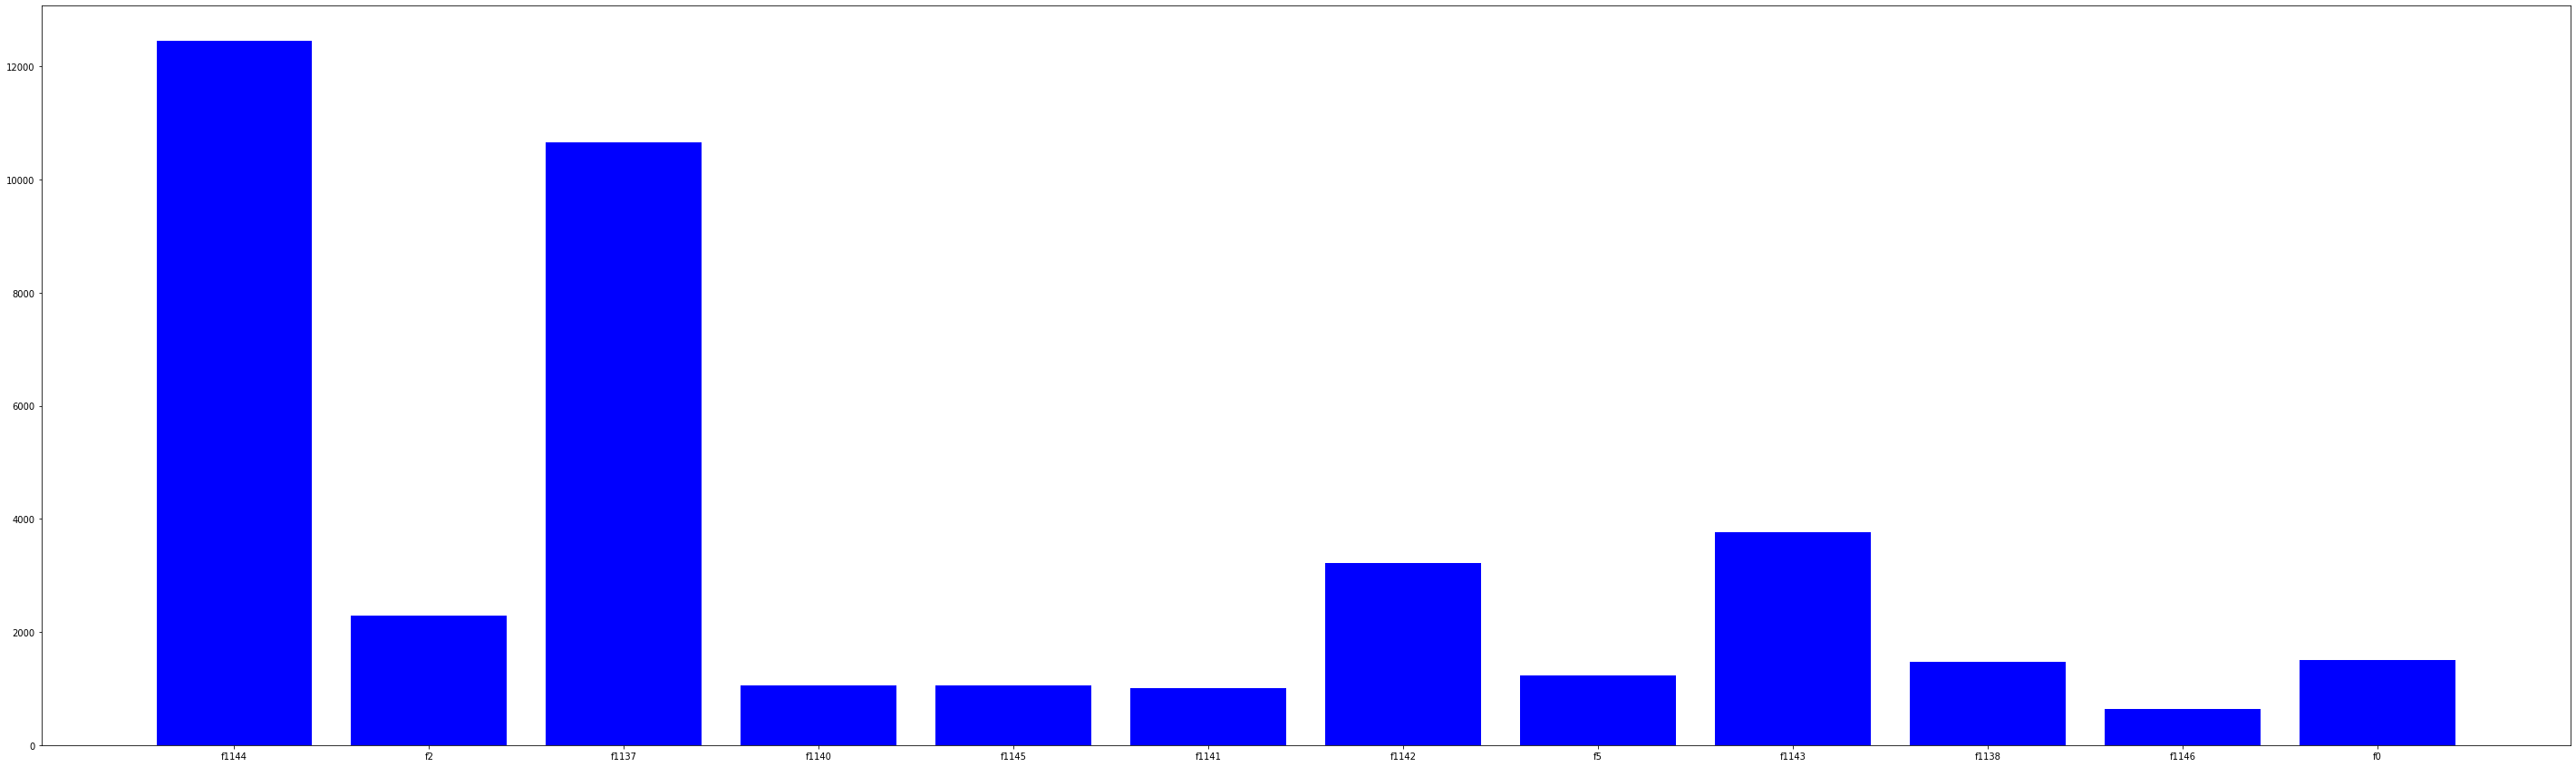

['f1144', 'f2', 'f1137', 'f1140', 'f1145', 'f1141', 'f1142', 'f5', 'f1143', 'f1138', 'f1146', 'f0']


In [21]:
def get_feature_analyze_use_gb_model(x_train, y_train):
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=8, n_estimators=1000, subsample=1, learning_rate=0.05, seed=300)
    gbm.fit(x_train.values, y_train.values)
    imps = gbm.get_booster().get_fscore()
    _max = max(imps.items(), key=lambda k: k[1]) 
    _min = min(imps.items(), key=lambda k: k[1])
    # Берем признаки, у которых fscore не менее 5% от min...max вклада всех признаков
    threshold = (_max[1] - _min[1]) * 0.05 + _min[1]
    features = {k: v for (k, v) in imps.items() if v > threshold}
    # Отрисовываем гистограмму
    plt.figure(figsize=(50, 15))
    plt.bar(features.keys(), features.values(), color='b')
    plt.show()
    return list(features.keys())

fit_column = get_feature_analyze_use_gb_model(x_train, y_train)
print(fit_column)

# Метрики

In [22]:
def rmspe(target, predict):
    return np.sqrt((((target - predict) / target) ** 2).mean())

# Подбор параметров обучения
Подбираем параметры модели, фиксируем learning_rate на уровне 0.003, максимальную глубину ограничиваем на уровне 10ти, подбираем estimators, зависимость прямая, чем ниже learning_rate -> тем больше должен быть estimators

In [23]:
def fit(x_train, y_train, x_test, y_test, fit_column):
    errors = []
    scaler = scalers[-1]
    y1 = scaler[1].inverse_transform([y_test.values])[0]
    for e in range(5000, 10000, 250):
        gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=10, n_estimators=e, subsample=1, learning_rate=0.003, seed=700)
        gbm.fit(x_train[fit_column].values, y_train.values)
        # Тест: получаем предикт, проводим денормализацию, считаем ошибку
        y_pred = gbm.predict(x_test[fit_column].values)
        y2 = scaler[1].inverse_transform(y_pred.reshape(1, -1))[0]
        errors.append({'rmspe': rmspe(y1, y2), 'estimators': e})
    return pd.DataFrame.from_dict(errors)

errors_stat = fit(x_train, y_train, x_test, y_test, fit_column)

Анализируем полученные результаты

In [25]:
print(errors_stat)

    estimators     rmspe
0         5000  0.126066
1         5250  0.125614
2         5500  0.125303
3         5750  0.124987
4         6000  0.124752
5         6250  0.124467
6         6500  0.124225
7         6750  0.123908
8         7000  0.123549
9         7250  0.123362
10        7500  0.123223
11        7750  0.123029
12        8000  0.123033
13        8250  0.123008
14        8500  0.122944
15        8750  0.122855
16        9000  0.122751
17        9250  0.122707
18        9500  0.122692
19        9750  0.122681


Строим график зависимости rmspe(estimators)

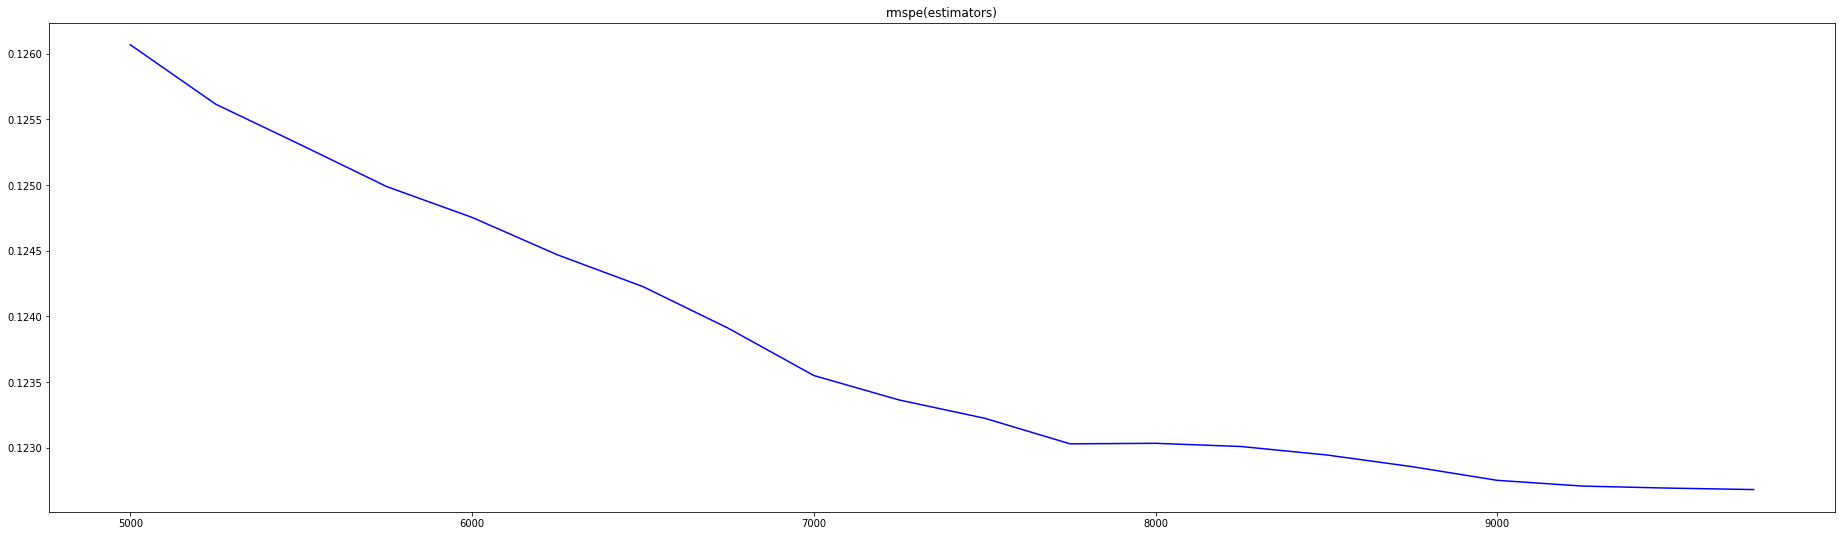

In [27]:
visualisation(errors_stat['estimators'], errors_stat['rmspe'], 'rmspe(estimators)')

Из графика видно, что нам необходимо оставить значение estimator на уровне 9000

In [ ]:
def get_model(x_train, y_train, fit_column):
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=10, n_estimators=9000, subsample=1, learning_rate=0.003, seed=700)
    gbm.fit(x_train[fit_column].values, y_train.values)
    return gbm

model = get_model(x_train, y_train, fit_column)

# Генерируем сабмишн


In [ ]:
test_df = pd.read_csv(test_path, sep=',', index_col=False)
# Добавляем пустой столбец 'Sales', чтобы использовать метод prepare_data
test_df['Sales'] = np.zeros(test_df.shape[0])
df = prepare_data(test_df, store_df)
x, y = get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns, split=False)